# Reinforcement learning with Proximal Policy Optimization PPO

In [1]:
from typing import List, Tuple, Union

import lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import torch
from torch.utils.data import DataLoader
import torch.optim as optim 
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

try:
    import gymnasium as gym
except ModuleNotFoundError:
    _GYM_AVAILABLE = False
else:
    _GYM_AVAILABLE = True
import solution

%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Generating cart pole trajectories
We first create a class that will simulate the classic cart pole problem using the CartPole environment from the gymnasium package.

In [8]:
class TrajectoryGenerator(pl.LightningDataModule):

    def __init__(self, env: str = 'CartPole-v1', agent=None, batch_size=128, gamma: float = 0.99,
                 lam: float = 0.95, max_episode_len=1000):
        super().__init__()
        self.agent = agent
        self.env = gym.make(env, render_mode='rgb_array')
        self.state = torch.FloatTensor(self.env.reset()[0])
        self.device = 'cpu'
        self.batch_size = batch_size

        self.gamma = gamma
        self.lam = lam
        self.max_episode_len = max_episode_len

        self.episode_step = 0
        self.avg_ep_reward = 0
        self.avg_ep_len = 0
        self.avg_reward = 0

        self.batch_states = []

        self.batch_actions = []
        self.batch_adv = []
        self.batch_d_rewards = []
        self.batch_logp = []

        self.ep_rewards = []
        self.ep_values = []
        self.epoch_rewards = []

    def setup(self, stage: str) -> None:
        pass

    def discount_rewards(self, rewards: List[float], discount: float) -> List[float]:
        """Calculate the discounted rewards of all rewards in list
        Args:
            rewards: list of rewards/advantages
        Returns:
            list of discounted rewards/advantages
        """

        assert isinstance(rewards[0], float)

        cumul_reward = []
        sum_r = 0.0

        for r in reversed(rewards):
            sum_r = (sum_r * discount) + r
            cumul_reward.append(sum_r)

        return list(reversed(cumul_reward))

    def calc_advantage(self, rewards: List[float], values: List[float], last_value: float) -> List[float]:
        """Calculate the advantage given rewards, state values, and the last value of episode
        Args:
            rewards: list of episode rewards
            values: list of state values from critic
            last_value: value of last state of episode
        Returns:
            list of advantages
        """

        rews = rewards + [last_value]
        vals = values + [last_value]
        # GAE
        delta = [rews[i] + self.gamma * vals[i + 1] - vals[i] for i in range(len(rews) - 1)]
        adv = self.discount_rewards(delta, self.gamma * self.lam)

        return adv

    def generate_trajectories(self, agent=None):
        num_max_steps = 2048
        max_episode_len = 1000
        agent = agent or self.agent
        for step in range(num_max_steps):
            pi, action, log_prob, value = agent(self.state)
            next_state, reward, done, *_ = self.env.step(action.cpu().numpy())

            self.episode_step += 1

            self.batch_states.append(self.state)
            self.batch_actions.append(action)
            self.batch_logp.append(log_prob)

            self.ep_rewards.append(reward)
            self.ep_values.append(value.item())

            self.state = torch.FloatTensor(next_state)

            epoch_end = step == (num_max_steps - 1)
            terminal = len(self.ep_rewards) == max_episode_len

            if epoch_end or done or terminal:
                # if trajectory ends abtruptly, boostrap value of next state
                if (terminal or epoch_end) and not done:
                    with torch.no_grad():
                        _, _, _, value = agent(self.state)
                        last_value = value.item()
                        steps_before_cutoff = self.episode_step
                else:
                    last_value = 0
                    steps_before_cutoff = 0

                # discounted cumulative reward
                self.batch_d_rewards += self.discount_rewards(self.ep_rewards + [last_value], self.gamma)[:-1]
                # advantage
                self.batch_adv += self.calc_advantage(self.ep_rewards, self.ep_values, last_value)
                # logs
                self.epoch_rewards.append(sum(self.ep_rewards))
                # reset params
                self.ep_rewards = []
                self.ep_values = []
                self.episode_step = 0
                self.state = torch.FloatTensor(self.env.reset()[0])

            if epoch_end:
                self.train_data = (
                    torch.stack(self.batch_states), torch.stack(self.batch_actions), torch.stack(self.batch_logp),
                    torch.FloatTensor(self.batch_d_rewards), torch.FloatTensor(self.batch_adv))

                self.batch_states.clear()
                self.batch_actions.clear()
                self.batch_adv.clear()
                self.batch_logp.clear()
                self.batch_d_rewards.clear()

                # logging
                self.avg_reward = sum(self.epoch_rewards) / num_max_steps

                # if epoch ended abruptly, exlude last cut-short episode to prevent stats skewness
                epoch_rewards = self.epoch_rewards
                if not done:
                    epoch_rewards = epoch_rewards[:-1]

                total_epoch_reward = sum(epoch_rewards)
                nb_episodes = len(epoch_rewards)

                self.avg_ep_reward = total_epoch_reward / nb_episodes
                self.avg_ep_len = (num_max_steps - steps_before_cutoff) / nb_episodes

                self.epoch_rewards.clear()

    def train_dataloader(self) -> DataLoader:
        self.generate_trajectories()
        dataset = torch.utils.data.TensorDataset(*self.train_data)
        dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=self.batch_size)
        return dataloader

## MLPs for actor and critic networks (25P)

Write a function that can be used to create simple MLPs for the actor and critic networks. The function takes the shape of the input tensor, number of actions to output, and a list containing the hidden sizes for each of the hidden layers, where the length of the list determines the number of hidden layers. Use ReLU as a non-linearity.

In [9]:
def create_mlp(input_shape: Tuple[int], n_actions: int, hidden_sizes: list = [128, 128]):
    """
    Simple Multi-Layer Perceptron network
    
    param input_shape: Shape of input tensor
    param n_actions: Number of actions to output
    param hidden_sizes: List of sizes of hidden layers
    """
    net_layers = []
    # TODO: Implement layers for the MLP here 
    
    return torch.nn.Sequential(*net_layers)

## Discrete actor (10P)

Convert the output of the actor MLP into probabilities for each action $\pi_\theta(a_i^{(t)}|s^{(t)})$, and sample an action $a^{(t)}$ for the current state. 

In [10]:
class DiscreteActor(torch.nn.Module):

    def __init__(self, actor_net: torch.nn.Module):
        super().__init__()

        self.actor_net = actor_net

    def forward(self, states) -> Tuple[torch.distributions.Categorical, torch.Tensor]:
        '''

        :param states: state of environment
        :return: Probabilities of actions and chosen action
        '''
        # TODO: Calculate the probabilities and the action chosen by the actor
        pi, action = solution.discrete_actor_forward(self.actor_net, states)

        return pi, action

## Actor-critic (10P)

Combine the actor and critic networks to obtain the probabilities of the actions $\pi_\theta(a_i^{(t)}|s^{(t)})$, the sampled action $a^{(t)}$  and its log-probability $log\pi_\theta(a^{(t)}|s^{(t)})$, along with the value given by the critic for the current state $Q^{\pi_\theta}(s^{(t)}, a^{(t)})$. 

In [11]:
class ActorCritic(object):
    """
    Actor Critic Agent used during trajectory collection. It returns a
    distribution and an action given an observation.

    """

    def __init__(self, actor_net: torch.nn.Module, critic_net: torch.nn.Module):
        self.actor_net = actor_net
        self.critic_net = critic_net

    @torch.no_grad()
    def __call__(self, state: torch.Tensor) -> Tuple[
        torch.distributions.Categorical, torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param state:
        :return: Categorical distribution, action, log probability of action, critic value of state
        '''
        
        # TODO: Calculate the probabilities and the action chosen by the actor as well as the value returned by the critic
        pi, action, log_p, value = solution.actor_critic_call(self.actor_net, self.critic_net, state)

        return pi, action, log_p, value

## Proximal policy optimization

Implement the missing parts of the PPO module

**a)** Implement the actor loss for the PPO module $-\min \left(\frac{\pi_\theta(a \mid s)}{\pi_{\theta^{\prime}}(a \mid s)}, 1+\epsilon\right) A^{\pi_{\theta^{\prime}}}(a, s)$. **(25P)**

**b)** Implement the critic loss for the PPO module. $(Q^{\pi_\theta}(s, a) - \gamma R(s, a))^2$ **(10P)**

**c)** Visualize an episode performed by the model by collecting images representing the environment along a trajectory. The trajectory is generated by looping over the actions chosen by the model and the resulting states of the environment until the maximum number of steps or a failure state is reached. **(20P)**

In [12]:
class PPO(pl.LightningModule):

    def __init__(
            self,
            env: str,
            gamma: float = 0.99,
            lam: float = 0.95,
            lr_actor: float = 1e-3,
            lr_critic: float = 1e-3,
            max_episode_len: float = 1000,
            batch_size: int = 512,
            steps_per_epoch: int = 2048,
            clip_ratio: float = 0.2,
    ) -> None:

        super().__init__()

        if not _GYM_AVAILABLE:
            raise ModuleNotFoundError('This Module requires gym environment which is not installed yet.')

        # Hyperparameters
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.steps_per_epoch = steps_per_epoch
        self.batch_size = batch_size
        self.gamma = gamma  # only needed for trajectory
        self.lam = lam  # only needed for trajectory
        self.max_episode_len = max_episode_len
        self.clip_ratio = clip_ratio  # epsilon
        self.automatic_optimization = False
        self.save_hyperparameters()

        self.env = gym.make(env, render_mode='rgb_array')
        self.critic = solution.create_mlp(self.env.observation_space.shape, 1)
        actor_mlp = solution.create_mlp(self.env.observation_space.shape, self.env.action_space.n)
        self.actor = DiscreteActor(actor_mlp)

        self.agent = ActorCritic(self.actor, self.critic)

        self.batch_states = []
        self.batch_actions = []
        self.batch_adv = []
        self.batch_d_rewards = []
        self.batch_logp = []

        self.ep_rewards = []
        self.ep_values = []
        self.epoch_rewards = []

        self.episode_step = 0
        self.avg_ep_reward = 0
        self.avg_ep_len = 0
        self.avg_reward = 0

        self.state = torch.FloatTensor(self.env.reset()[0])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Passes in a state x through the network and returns the policy and a sampled action
        Args:
            x: environment state
        Returns:
            Tuple of policy and action
        """
        action_prob, action = self.actor(x)
        value = self.critic(x)

        return action_prob, action, value

    def actor_loss(self, state, action, logp_old, advantage) -> torch.Tensor:
        """
        Calculate the actor loss.

        Args:
            state: current state of environment
            action: selected action
            logp_old: old log-probability
            advantage: advantage of action
        Returns:
            loss
        """
        # TODO: Implement the PPO Actor Loss
        loss_actor = solution.get_actor_loss(self.actor, state, action, logp_old, advantage, self.clip_ratio)
        
        return loss_actor

    def critic_loss(self, state: torch.Tensor, d_reward: torch.Tensor) -> torch.Tensor:
        """
        Calculate the critic loss.

        Args:
            state: current state of environment
            d_reward: discounted reward
        Returns:
            loss
        """
        # TODO: Implemente the PPO Critic Loss
        loss_critic = solution.get_critic_loss(self.critic, state, d_reward)
        
        return loss_critic

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        """
        Carries out a single update to actor and critic network from a batch of replay buffer.

        Args:
            batch: batch of replay buffer/trajectory data
            batch_idx: used for logging
            optimizer_idx: idx that controls optimizing actor or critic network
        Returns:
            loss
        """
        optims = self.optimizers()
        optim = optims[0] if batch_idx % 2 == 0 else optims[1]
        optim.zero_grad()

        state, action, old_logp, d_reward, advantage = batch

        # normalize advantages
        advantage = (advantage - advantage.mean()) / advantage.std()

        self.log("avg_ep_len", self.trainer.datamodule.avg_ep_len, prog_bar=True, on_step=False, on_epoch=True)
        self.log("avg_ep_reward", self.trainer.datamodule.avg_ep_reward, prog_bar=True, on_step=False, on_epoch=True)
        self.log("avg_reward", self.trainer.datamodule.avg_reward, prog_bar=True, on_step=False, on_epoch=True)

        if batch_idx % 2 == 0:
            loss_actor = self.actor_loss(state, action, old_logp, advantage)
            self.log('loss_actor', loss_actor, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.manual_backward(loss_actor)
            optim.step()

            return loss_actor

        elif batch_idx % 2 == 0:
            loss_critic = self.critic_loss(state, d_reward)
            self.log('loss_critic', loss_critic, on_step=False, on_epoch=True, prog_bar=False, logger=True)
            self.manual_backward(loss_critic)
            optim.step()

            return loss_critic

    def viz_agent(self):
        '''
        Visualize actions of the trained agent in environment in a loop, you should use the built in env.render() functionality
        :return:
        '''
        
        imgs = []
        fig = plt.figure()
        state = torch.FloatTensor(self.env.reset()[0])
        img = self.env.render()
        imgs.append(img)
        
        # TODO: implement full evaluation loop of environment and use env.render() to get images
        state_imgs = solution.get_step_images(self.agent, state, self.env, self.max_episode_len)
        imgs += state_imgs
                 
        im = plt.imshow(imgs[0])
        print('Episode length', len(imgs))
        def animate(i):
            im.set_array((imgs[i]))
            return [im]
        
        anim = FuncAnimation(fig, animate, frames=len(imgs), interval=20)
        return anim


    def configure_optimizers(self) -> List[Optimizer]:
        """ Initialize Adam optimizer"""
        optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr_critic)

        return optimizer_actor, optimizer_critic

In [13]:
# create lightning module
env: str = 'CartPole-v1'
model = PPO(env)
traj_gen = TrajectoryGenerator(env=env, agent=model.agent)

#  You should achieve an average episode score of > 200 after 50 epochs
trainer = Trainer(max_epochs=100, accelerator='cpu', reload_dataloaders_every_n_epochs=1)
res = trainer.fit(model, datamodule=traj_gen)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mihail/miniconda3/envs/equiv_dens/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name   | Type          | Params
-----------------------------------------
0 | critic | Sequential    | 17.3 K
1 | actor  | DiscreteActor | 17.4 K
-----------------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params
0.139     Total estimated model params size (MB)
/home/mihail/miniconda3/envs/equiv_dens/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value o

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 209.07it/s, v_num=12, avg_ep_len=350.0, avg_ep_reward=350.0, avg_reward=1.000, loss_actor=0.00162]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 198.04it/s, v_num=12, avg_ep_len=350.0, avg_ep_reward=350.0, avg_reward=1.000, loss_actor=0.00162]


<IPython.core.display.Javascript object>


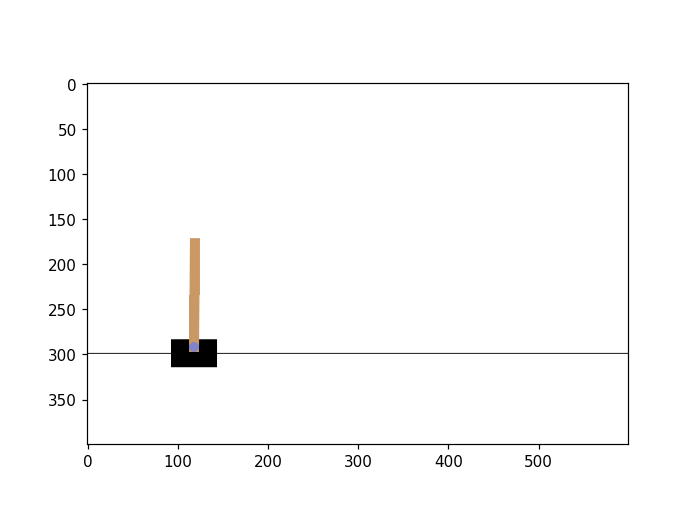

Episode length 185


In [14]:
model.viz_agent()